In [1]:
import warnings
warnings.filterwarnings('ignore')
import DataCollector as collector
dc = collector.DataCollector()
import ModelTrainer as trainer
mt = trainer.ModelTrainer()
import FeaturePreparer as preparer
fp = preparer.FeaturePreparer()

In [2]:
dc._init_()
data = dc.loadData()

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

data = data.sample(0.01)
data_pd = data.toPandas()

columns = ['CSTARTTIME','CSERVICE','CSENDERENDPOINTID','CSENDERPROTOCOL','CINBOUNDSIZE','year', 'month', 'day', 'hour', 'minute']
xtrain, xtest, ytrain, ytest = train_test_split(data_pd[columns], data_pd['outcome'], test_size=0.3, shuffle=True)

classifier = XGBClassifier()
model = classifier.fit(xtrain, ytrain)

In [7]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xtest)

In [8]:
print(shap_values)

[[ 0.2819786   0.12895755  0.25881395 ...  0.02022834 -0.0321242
   0.07003899]
 [ 0.05802069  0.06303911  0.09621884 ...  0.16742212  0.12032025
   0.14945619]
 [ 0.04377156  0.11159936  0.25200483 ...  0.13494411 -0.44091362
  -0.03024102]
 ...
 [ 0.8042676  -0.42020643 -0.41408172 ...  0.19258071  0.08429402
  -0.03159344]
 [-0.39785376 -0.03950504  0.08465017 ...  0.0469883   0.23493665
   0.13163407]
 [-1.2238828  -0.28095356  0.4303645  ... -0.00207904  0.16612615
  -0.16236193]]


In [ ]:
import shap
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

boost = model.get_booster()
X_train = train_data.select('features').toPandas()

shap.initjs()
explainer = shap.TreeExplainer(boost)
shap_values = explainer.shap_values(X_train)
'''
rows_list = []
for row in X_train.rdd.collect(): 
  dict1 = {}
  dict1.update({k:v for k,v in zip(X_train.columns,row.features)})
  rows_list.append(dict1)
pandas_df = pd.DataFrame(rows_list)

shap.initjs()
shap_values = boost.get_fscore()
shap.summary_plot(shap_values, pandas_df, plot_type="bar")



import matplotlib.pyplot as plt

columns = ['CSTARTTIME','CSERVICE','CSENDERENDPOINTID','CSENDERPROTOCOL','CINBOUNDSIZE','year', 'month', 'day', 'hour', 'minute']

feature_importances = boost.get_fscore()
feature_importances_pd = pd.DataFrame([feature_importances])
feature_importances_pd = feature_importances_pd.rename(columns={"f0": "CSTARTTIME", "f1": "CSERVICE","f2": "CSENDERENDPOINTID", "f3": "CSENDERPROTOCOL","f4": "CINBOUNDSIZE", "f5": "year","f6": "month", "f7": "day","f8": "hour", "f9": "minute"})'''

# Evaluation

In [7]:
test_data=spark.read.parquet(mt.test_path_1)
train_data=spark.read.parquet(mt.train_path_1)

In [8]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="outcome", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
prediction = model.transform(test_data)

# Get metrics
acc = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(prediction)

### Metrics

In [9]:
print("Accuracy: " +str(acc))
print("F1: " +str(f1))
print("Precision: " +str(weightedPrecision))
print("Recall: " +str(weightedRecall))
print("Auc: " +str(auc))

Acc :0.9886631016042781
F1 :0.9850513986265641
weightedPrecision :0.9849253404986271
weightedRecall :0.9886631016042781
auc :0.5630952380952381


### Confusion Matrix

In [10]:
prediction.groupBy('outcome', 'prediction').count()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND outcome = prediction').count()
TP = prediction.filter('prediction = 1 AND outcome = prediction').count()
FN = prediction.filter('prediction = 0 AND outcome = 1').count()
FP = prediction.filter('prediction = 1 AND outcome = 0').count()

cm = [[TN, FP],[FN, TP]]

<Axes: >

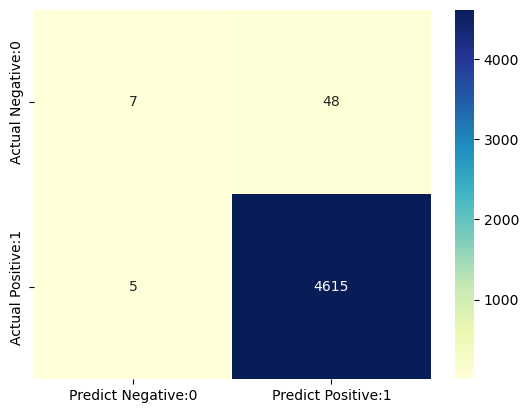

In [11]:
import seaborn as sns
import pandas as pd

cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'],
                         index=['Actual Negative:0', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### SHAP Explanations

In [25]:
import shap

boost = model.get_booster()

columns = ['CSTARTTIME','CSERVICE','CSENDERENDPOINTID','CSENDERPROTOCOL','CINBOUNDSIZE','year', 'month', 'day', 'hour', 'minute']
test = test_data.select('features')
test = test.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(columns)

test_pd =test.toPandas()

shap.initjs()
explainer = shap.TreeExplainer(boost)
shap_values = explainer.shap_values(test_pd)

In [26]:
shap.force_plot(explainer.expected_value, shap_values[0,:], test_pd.iloc[0,:])

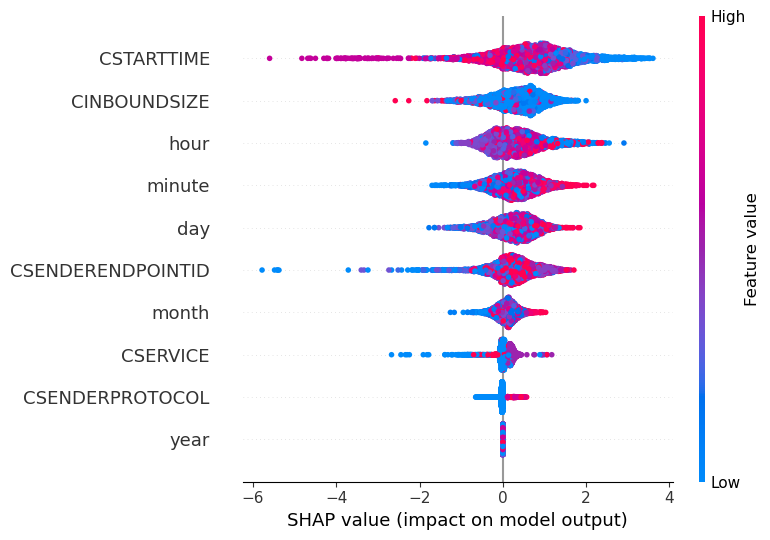

In [31]:
shap.summary_plot(shap_values, test_pd)

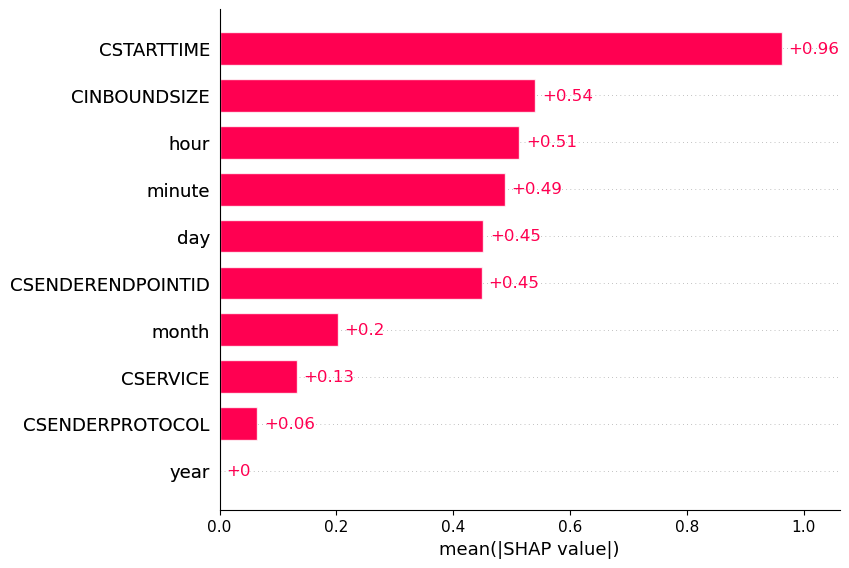

In [29]:
shap.plots.bar(explainer(test_pd))

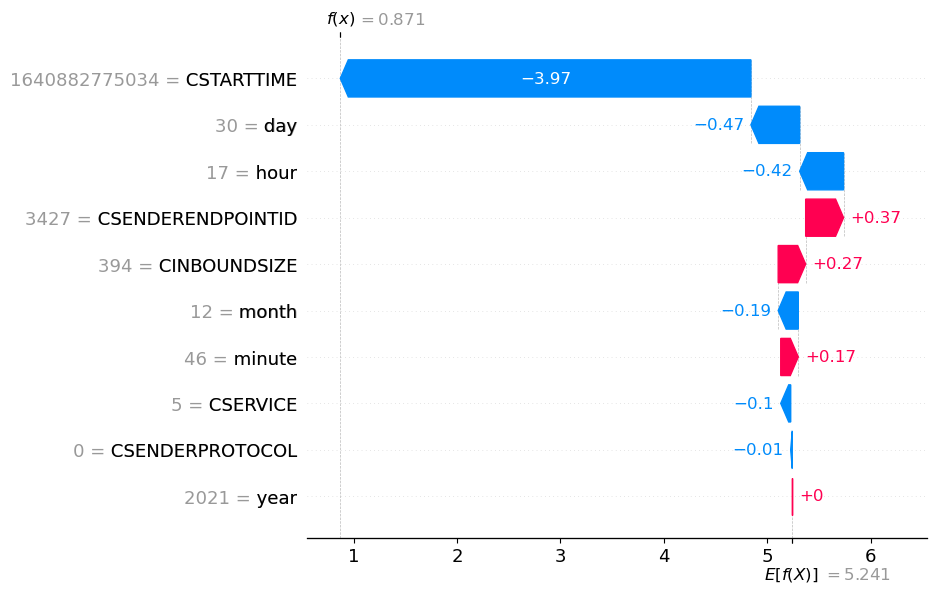

In [34]:
shap.plots.waterfall(explainer(test_pd)[0], max_display=14)